In [2]:
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
%matplotlib inline
import galsim
import os
import math
import logging
import sys
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.coordinates import SphericalRepresentation, CartesianRepresentation

In [3]:
simname = "/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/mag2/Chinchilla-4-y3wlpz.0.fits"
truthname = "/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/truth/truth/Chinchilla-4_lensed.4.fits"

In [4]:
simhdu = fits.open(simname)
truthhdu = fits.open(truthname)

In [5]:
#simhdu.info()
sim_table = simhdu[1].data
#print(sim_table.columns);

#truthhdu.info()
truth_table = truthhdu[1].data
#print(truth_table.columns)

In [6]:
cat_file_name = os.path.join('/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/truth/truth/','Chinchilla-4_lensed.4.fits')
cat = galsim.Catalog(cat_file_name)

In [54]:
noisy_file_name = os.path.join('/afs/slac.stanford.edu/u/ki/gwisk/CRNProject','noisy.fits')
noisefree_file_name = os.path.join('/afs/slac.stanford.edu/u/ki/gwisk/CRNProject','noisefree.fits')
nfimages, nimages, results, matrices, rotations, gfluxes =([] for i in range(6))

rband = truth_table['LMAG'][:,1] #grizy
te1 = truth_table['EPSILON'][:,0]
te2 = truth_table['EPSILON'][:,1]

# half light radius squared/flux
for i in range(0, 10):
    # catalogs
    ra = cat.get(i, 'RA')
    dec = cat.get(i, 'DEC')
    hlr = cat.get(i, 'SIZE')

    # more catalogs
    elip1 = te1[i]
    elip2 = te2[i]
    lmag = rband[i]
    gflux = 10**((lmag-22.5)/(-2.5))
    noise =  0.2
    gfluxes.append(gflux)
    gal = galsim.Gaussian(flux=gflux, half_light_radius=hlr)
    # shearing and transformation matrix
    shearing = galsim.Shear(e1=elip1, e2=elip2)
    gal = gal.shear(shearing)
    matrix = (shearing.getMatrix())
    matrices.append(matrix)
    rng = galsim.BaseDeviate(8241573+i+1)
    # create image, convolve
    
    final1 = galsim.Convolve([gal])
    final2 = galsim.Convolve([gal])
    image1 = galsim.ImageF(40, 40)
    image2 = galsim.ImageF(40, 40)
    final1.drawImage(image1, scale=0.2)

    nfimages.append(image1)
    
    final2.drawImage(image2, scale=0.2)
    image2.addNoise(galsim.GaussianNoise(rng, 0.005*gflux))
    nimages.append(image2) 

galsim.fits.writeMulti(nimages, noisy_file_name)
galsim.fits.writeMulti(nfimages, noisefree_file_name)

In [43]:
from astropy.utils.data import get_pkg_data_filename
noisy_image_file = get_pkg_data_filename('/afs/slac.stanford.edu/u/ki/gwisk/CRNProject/noisy.fits')
noisefree_image_file = get_pkg_data_filename('/afs/slac.stanford.edu/u/ki/gwisk/CRNProject/noisefree.fits')

In [60]:
dfluxes = []
for i in range(9):
    noisy_image_data = fits.getdata(noisy_image_file, ext = i)
    noisefree_image_data = fits.getdata(noisefree_image_file, ext = i)
    dfluxes.append(np.sum(noisy_image_data)-np.sum(noisefree_image_data))
print(dfluxes)

[-0.008884713, -0.0109423995, -0.195979, 0.020815298, -0.19618636, -0.004044473, 0.009525523, -0.006081775, 0.057065874]


<Figure size 432x288 with 0 Axes>

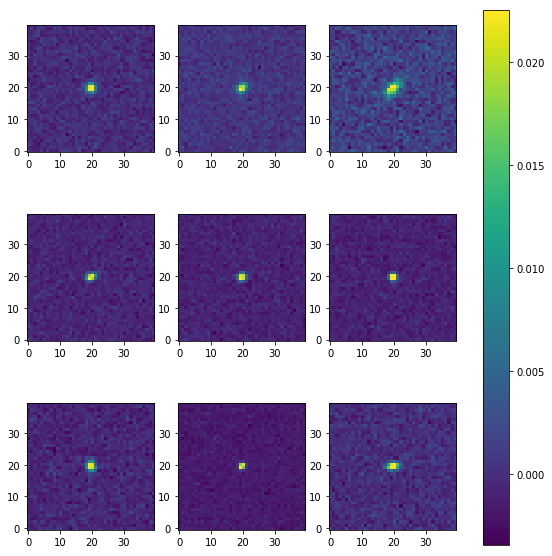

In [67]:
plt.figure(1)
fluxes = []
f, ax = plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    image_data = fits.getdata(noisy_image_file, ext = i)
    im = ax[i//3, i%3].imshow(image_data, origin="lower")
plt.tight_layout(1)
plt.colorbar(im, ax=ax)

<Figure size 432x288 with 0 Axes>

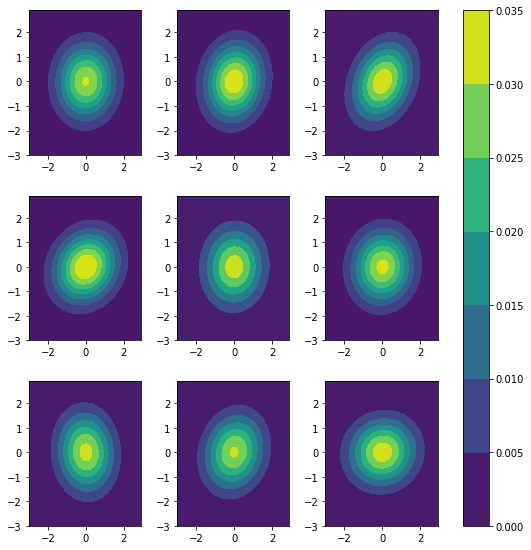

In [151]:
import scipy.integrate as integrate
plt.figure(2)
g, ax = plt.subplots(3, 3, figsize=(8, 8))
x, y = np.mgrid[-3:3:.1, -3:3:.1]
pos = np.zeros(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y

for j in range(0, 9):
        rv = multivariate_normal([0, 0], matrices[j])
       # result = integrate.dblquad(lambda x, y: gfluxes[j]*rv.pdf([x, y]), -np.inf, np.inf, lambda y: -np.inf, np.inf)
        integral.append(result)
        im = ax[j//3, j%3].contourf(x, y, gfluxes[j]*rv.pdf(pos))
plt.tight_layout(2)
plt.colorbar(im, ax=ax)

In [129]:
rv = multivariate_normal([0, 0], matrices[1])
result = integrate.dblquad(lambda x, y: 1.5*rv.pdf([x, y]), -np.inf, np.inf, lambda y: -np.inf, np.inf)
print(result)

(1.5000000018927728, 1.4475699337492638e-08)
